In [1]:
# libraries
import os
import numpy as np
from rag_module.rag import RAG

c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inspection

In [5]:
# simple test
rag = RAG(use_reranker=False)
rag.query("What is the capital of France?")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00, 47.12it/s]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'chunks': [{'filename': '03-regions.md',
   'text': '## Choosing a suitable region  \nSome regions are being used more than others. The `West Europe` region is a popular region often used as the default region by Dutch (and other European) parties. But this is a heavily used region that sometimes runs out of capacity. When this happens, you are not able to deploy new instances of certain resources. This is a continuity risk for your customers.  \nIn order to mitigate this risk, make sure you plan ahead and always consider use of multiple regions. You could for instance deploy your _production_ environments to `West Europe` (because this region introduces the least amount of network latency for instance) and all _development_ and _test_ environments to another region. Good alternative regions to use are `France Central` or `Sweden Central`.  \n> **Guideline:** Consider using multiple Azure regions in your Azure deployment strategy.\n> **Why:** Mitigate the risk of not being able to dep

### Evaluation

In [5]:
import pandas as pd

In [ ]:
queries = [
    'Which database should be used for graphs?',
    'Welke database moet ik gebruiken voor grafieken?',
    'Welke database moet ik gebruiken voor graphs?'
    ]

df = pd.DataFrame(queries, columns=["Query"])
df.to_excel("./evaluation/evaluation.xlsx", index=False)

In [ ]:
df = pd.read_excel("./evaluation/evaluation.xlsx")
queries = df["Query"].tolist()

In [11]:
# RAGs to evaluate
rags = {
    "RAG-bl": RAG(use_reranker=False),
    "RAG-1": RAG(reranker_name="flashrank", retrieve_top_k=15),
    "RAG-2": RAG(reranker_name="cross-encoder", retrieve_top_k=15),
    "RAG-3": RAG(reranker_name="cross-encoder", retrieve_top_k=30)
}

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default cross-encoder model for language en
If your model is NOT intended to be ran as a one-label cross-encoder, please reload it and specify the model_type! Otherwise, you may ignore this warning. You may specify `model_type='cross-encoder'` to suppress this warning in the future.
Default Model: mixedbread-ai/mxbai-rerank-base-v1
Loading TransformerRanker model mixedbread-ai/mxbai-rerank-base-v1 (this message can be suppressed by setting verbose=0)
No device set
Using device cpu
No dtype set
Using dtype torch.float32
Loaded model mixedbread-ai/mxbai-rerank-base-v1
Using device cpu.
Using dtype torch.float32.


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading default cross-encoder model for language en
If your model is NOT intended to be ran as a one-label cross-encoder, please reload it and specify the model_type! Otherwise, you may ignore this warning. You may specify `model_type='cross-encoder'` to suppress this warning in the future.
Default Model: mixedbread-ai/mxbai-rerank-base-v1
Loading TransformerRanker model mixedbread-ai/mxbai-rerank-base-v1 (this message can be suppressed by setting verbose=0)
No device set
Using device cpu
No dtype set
Using dtype torch.float32
Loaded model mixedbread-ai/mxbai-rerank-base-v1
Using device cpu.
Using dtype torch.float32.


In [ ]:
def consistency_check(rag, queries):
    responses = [rag.query(query) for query in queries]
    answers = [response["answer"] for response in responses]
    vector_ids = [[chunk['vector_id'] for chunk in response['chunks']] for response in responses]
    n_unique_vectors = [len(set(ids)) for ids in vector_ids]
    return answers, vector_ids, n_unique_vectors

for i, rag in enumerate(rags):
    answers, vector_ids, n_unique_vectors = consistency_check(rag, queries)
    print(f"Answers: {answers}")
    print(f"Vector IDs: {vector_ids}")
    print(f"Unique vectors: {n_unique_vectors}")
    print("")

In [7]:
#dfqa = pd.read_csv('./evaluation/QA_sets/250305120857.csv')
dfqa = pd.read_csv('./evaluation/QA_sets/250318173604.csv')
dfqa.head()

,question,answer,chunk_id,chunk_text
0,What are some advantages and disadvantages of ...,### Advantages of Using Web Components:\n\n1. ...,995,## Framework vs. Web components \nOnce you've...
1,What are the advantages of using Lombok's `@lo...,Using Lombok's `@lombok.Data` annotation offer...,1342,"### Example \nFor example, by adding [`@lombo..."
2,What is the importance of differentiating betw...,Differentiating between business and technical...,347,# System scope & Context \n**Contents** \nSy...
3,What are the recommended storage formats for s...,"For tabular datasets, the recommended storage ...",1925,### Dataset storage formats for tabular data ...
4,What are the key strategies for eliminating wa...,The key strategies for eliminating waste in th...,1486,### Eliminate waste \n- Partially done work d...


In [14]:
queries = dfqa["question"].tolist()

for rag_name, rag in rags.items():
    all_chunk_ids = []
    for q in queries:
        chunks = rag.retrieve(q)
        chunk_ids = [chunk["vector_id"] for chunk in chunks]
        all_chunk_ids.append(chunk_ids)
    dfqa[rag_name] = all_chunk_ids

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
queries = dfqa["question"].tolist()

for rag_name, rag in rags.items():
    responses = [rag.query(query) for query in queries]
    answers = [response["answer"] for response in responses]
    vector_ids = [[chunk['vector_id'] for chunk in response['chunks']] for response in responses]
    recall_scores = [int(chunk_id in ids) for chunk_id, ids in zip(dfqa['chunk_id'], vector_ids)]
    dfqa[f"{rag_name} Answer"] = answers
    dfqa[f"{rag_name} Vector IDs"] = vector_ids
    dfqa[f"{rag_name} Recall"] = recall_scores
    print(f"Recall for {rag_name}: {dfqa[f'{rag_name} Recall'].mean()}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Recall for RAG-1: 1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Recall for RAG-2: 0.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Recall for RAG-3: 0.8


In [19]:
dfqa

,question,answer,chunk_id,chunk_text,RAG-bl,RAG-1,RAG-2,RAG-3
0,What are some advantages and disadvantages of ...,### Advantages of Using Web Components:\n\n1. ...,995,## Framework vs. Web components \nOnce you've...,"[995, 994, 993]","[995, 993, 994]","[995, 1265, 2071]","[995, 1265, 2071]"
1,What are the advantages of using Lombok's `@lo...,Using Lombok's `@lombok.Data` annotation offer...,1342,"### Example \nFor example, by adding [`@lombo...","[1342, 1344, 1343]","[1342, 1344, 1341]","[1342, 1341, 1344]","[1342, 1341, 1344]"
2,What is the importance of differentiating betw...,Differentiating between business and technical...,347,# System scope & Context \n**Contents** \nSy...,"[347, 902, 377]","[347, 902, 1019]","[347, 515, 690]","[347, 515, 690]"
3,What are the recommended storage formats for s...,"For tabular datasets, the recommended storage ...",1925,### Dataset storage formats for tabular data ...,"[1925, 1921, 1563]","[1925, 216, 1926]","[1925, 216, 1413]","[1925, 1412, 216]"
4,What are the key strategies for eliminating wa...,The key strategies for eliminating waste in th...,1486,### Eliminate waste \n- Partially done work d...,"[1486, 1485, 273]","[1486, 1484, 1485]","[1486, 1484, 1485]","[1486, 1484, 1485]"
5,What is the first step to take when selecting ...,The first step to take when selecting an SMTP ...,1614,## Check solutions in place \nFirst step in s...,"[1615, 1614, 1622]","[1614, 1615, 1622]","[1614, 1615, 1613]","[1614, 1615, 1613]"
6,How does the implementation of open ecosystems...,The implementation of open ecosystems like Ope...,1658,### Making observability actionable and scalab...,"[1658, 1624, 1864]","[1658, 1624, 1653]","[1658, 1624, 1653]","[1658, 1657, 1624]"
7,"What are some key features of VoiceOver, the b...","VoiceOver, the built-in screen reader on iOS, ...",1396,### VoiceOver (iOS) \nVoiceOver is the built-...,"[1396, 1397, 1395]","[1396, 1397, 1395]","[1396, 1398, 1397]","[1396, 1398, 1397]"
8,What is the process for uninstalling the old v...,To uninstall the old version of Java installed...,1126,## WSL Configuration \n### Java installation ...,"[1126, 1121, 1122]","[1126, 1123, 1130]","[1126, 1123, 1130]","[1126, 1127, 1123]"
9,What is the purpose of the provided XML snippe...,The provided XML snippet serves the purpose of...,1452,### Logging error responses \nBy default the ...,"[1452, 1284, 1668]","[1452, 1447, 1284]","[1452, 1231, 1447]","[1452, 1231, 1447]"


### rest

In [7]:
# test ability to read tables
q = "List the Alphas from the architecture essence checklist."
response = rag.query(q)
print(response["answer"])

The Alphas from the architecture essence checklist are:

1. **Opportunity**
2. **Stakeholders**
3. **Requirements**
4. **SoftwareSystem**
5. **Work**
6. **WayOfWorking**


In [8]:
# test complex ability to read tables
q = "What is the first phase of the essence scan and which artifacts exist in this phase for the requirements Alpha?"
response = rag.query(q)
print(response["answer"])

The first phase of the essence scan is the "Inception" phase. In this phase, the following artifacts exist for the "Requirements" Alpha:

- [Customer needs](../../03-architecture-guidance/05-artifacts/customer-needs.md)
- [Business case](../../03-architecture-guidance/05-artifacts/business-case.md)
- [Sales debt](../../03-architecture-guidance/05-artifacts/sales-debt.md)


In [10]:
q = "What percentage of lines can be duplicated during quality control?"
response = rag.query(q)
print(response["answer"])

Based on the provided context, there is no explicit mention of a specific percentage of lines that can be duplicated during quality control. The context discusses various aspects of quality control, including unit tests, security risks, maintainability, and bug detection. However, it does not provide a numerical guideline for the duplication of lines of code.

If you are looking for a general guideline on code duplication, it is often recommended to keep the duplication rate below 10-15% of the total codebase. This is because excessive duplication can lead to maintenance challenges and potential bugs. However, this is a general guideline and may vary depending on the specific context and requirements of your project.


In [28]:
response

{'chunks': [{'filename': 'conventions.md',
   'text': '## Definition of quality  \n- The conventions are captured and maintained.\n- The conventions are actively applied, reviewed and monitored.',
   'vector_id': 905,
   'distance': np.float32(1.1529663)},
  {'filename': 'architecture-peer-review.md',
   'text': '## Definition of quality  \n- No high impact issues left\n- Other issues are addressed',
   'vector_id': 38,
   'distance': np.float32(1.1719854)},
  {'filename': '01-automated-quality-control.md',
   'text': '## Aggregated quality control  \nA part of quality control is the unit tests you write to prove the application is doing what it is supposed to do.  \nHowever, there are more checks to validate the quality of your application:  \n- Security risks\n- Maintainability of code\n- Bug detection  \nIdeally you would like one tool to determine whether your application has sufficient quality to go to production. One tool to give all the feedback you need to improve your code to 

In [ ]:
# view chunk with vector id 2465
chunk = rag.embedder.chunkdata[2465]
print(chunk)

{'filename': '01-automated-quality-control.md', 'text': '### Conditions on `new code`  \nConditions on _new code_ apply to all branches and to Pull Requests.  \n| Metric | Operator | Value |\n| -------------------------- | -------- | ----- |\n| Coverage | >= | 80.0% |\n| Duplicated Lines (%) | <= | 3.0% |\n| Maintainability Rating | = | A |\n| Blocker Issues | = | 0 |\n| Critical Issues | = | 0 |\n| Major Issues | = | 0 |\n| Minor Issues | = | 0 |\n| Unit Test Success (%) | = | 100% |\n| Vulnerabilities | = | 0 |\n| Reliability Rating | = | A |\n| Security Hotspots Reviewed | = | 100% |\n| Security Rating | = | A |', 'vector_id': 2465}


In [11]:
q = "Who is the MLOps Accelerator?"
response = rag.query(q)
print(response["answer"])

The MLOps Accelerator is maintained by Willem Meints.


In [32]:
response

{'chunks': [{'filename': 'index.md',
   'text': '| [MLOps Accelerator](https://gitlab.infosupport.com/guidance-framework/azure-mlops-accelerator) | Willem Meints | <span class="status">Public Preview</span> |  \n> Please contact maintainers for access to accelerators that are in Private Preview.  \n> Looking for the .NET Microservice sample app? Microsoft sample apps are now available [here](../04-technology-guidance/02-application-development/03-frameworks/01-microsoft/samples.md).',
   'vector_id': 2924,
   'distance': np.float32(0.7947072)},
  {'filename': 'index.md',
   'text': '# Accelerators  \nAccelerators are sample solutions that contain proven technologies and best practices to help you deliver value quickly.  \n| Accelerator | Maintainers | Status |\n| ------------------------------------------------------------------------------------------------------------- | -------------- | :----------------------------------------: |\n| [Azure iPaaS Accelerator](https://gitlab.infosupp

In [12]:
q = "Heeft Info Support een code style voor Java?"
response = rag.query(q)
print(response["answer"])

Ja, Info Support heeft een code style voor Java. De code style wordt vaak geïmplementeerd door het gebruik van een code editor zoals IntelliJ IDEA, die ondersteuning biedt voor code stijl en best practices. Daarnaast kan Info Support gebruik maken van tools zoals Checkstyle, PMD of SpotBugs om de code te controleren en te beïnvloeden op de gewenste code stijl.

Als je specifieke vragen hebt over de code stijl van Info Support, kun je deze vragen ook stellen.


In [13]:
response

{'chunks': [{'filename': '20-coding-conventions.md',
   'text': '## Security  \nFollow the guidelines in\n[Secure Coding Guidelines](https://www.oracle.com/java/technologies/javase/seccodeguide.html).',
   'vector_id': 1146,
   'distance': np.float32(0.9801399)},
  {'filename': '15-intellij-wsl-and-java.md',
   'text': '## Install IntelliJ Ultimate  \nDownload the IDE here: [IntelliJ IDEA – the Leading Java and Kotlin IDE (\njetbrains.com)](https://www.jetbrains.com/idea/)',
   'vector_id': 1125,
   'distance': np.float32(1.0228661)},
  {'filename': '01-code-generation-libraries.md',
   'text': '## Lombok  \n[Project Lombok](https://projectlombok.org/) uses Java annotations to save you from writing a lot of boilerplate-style code.\nIt is implemented as a compiler plug-in (emitting bytecode) and usually added as a dependency in your build system.',
   'vector_id': 1341,
   'distance': np.float32(1.0401319)}],
 'query': 'Heeft Info Support een code style voor Java?',
 'answer': 'Ja, Info

## Explanations

In [54]:
# devide answer into sentences
import re

def split_into_sentences(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    return [s for s in sentences if s]  # Remove empty strings

sentences = split_into_sentences(response["answer"])

# measure similarity between sentences and chunks
def similarity(sentence, chunk):
    return np.dot(sentence, chunk) / (np.linalg.norm(sentence) * np.linalg.norm(chunk))

sentence_vectors = rag.embedder.encode(sentences)
chunk_vectors = rag.embedder.encode([chunk["text"] for chunk in response["chunks"]])

similarity_matrix = np.zeros((len(sentences), len(chunk_vectors)))

for i, sentence in enumerate(sentence_vectors):
    for j, chunk in enumerate(chunk_vectors):
        similarity_matrix[i, j] = similarity(sentence, chunk)

similarity_matrix

array([[0.68523639, 0.27313352, 0.87632006],
       [0.94104105, 0.37541759, 0.77899438]])

In [55]:
most_similar_chunk = np.argmax(similarity_matrix, axis=1)
citations = [f'[{chunk_idx}]' for chunk_idx in most_similar_chunk]
cited_sentences = [f"{sentence}{citation}" for sentence, citation in zip(sentences, citations)]
cited_text = " ".join(cited_sentences)

print(cited_text)

For graph databases, you should use **Azure Cosmos DB with the Gremlin API**.[2] This is the only managed graph database offered in Azure.[0]


In [56]:
# print citations with filenames
for i, chunk_idx in enumerate(most_similar_chunk):
    chunk = response["chunks"][chunk_idx]
    print(f"[{chunk_idx}] \n{chunk['text']}\n")

[2] 
### Azure Cosmos DB (Gremlin API)  
With the [Gremlin API in Azure Cosmos DB](https://docs.microsoft.com/en-us/azure/cosmos-db/graph-introduction) you can create and query large graphs.  
> **Guidance:** Use **Azure Cosmos DB with the Gremlin API** for graph databases.
> **Why:** This is the only managed graph database offered in Azure.

[0] 
## Graph database  
For graph databases there is a single managed offering in Azure.



## Research

number of documents: 2
number of chunks: 7427
average chunk size: 105.0


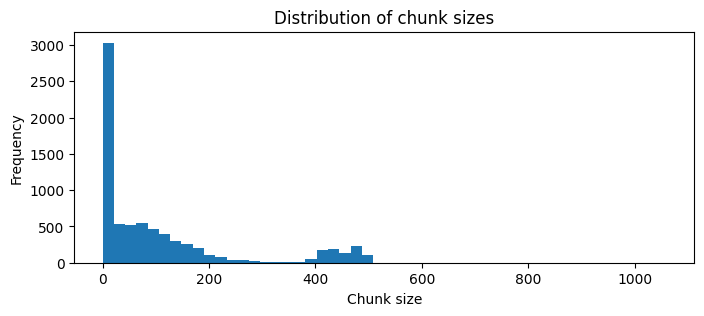

In [ ]:
import matplotlib.pyplot as plt

# number of chunks
n_chunks = len(rag.embedder.chunkdata)
print(f'number of chunks: {n_chunks}')

# average chunk size
avg_chunk_size = sum([len(chunk['text']) for chunk in rag.embedder.chunkdata]) / n_chunks
print(f'average chunk size: {round(avg_chunk_size, 0)}')

# plot distribution of chunk sizes
plt.figure(figsize=(8,3))  # Set the figure size
chunk_sizes = [len(chunk['text']) for chunk in rag.embedder.chunkdata]
plt.hist(chunk_sizes, bins=50)
plt.xlabel('Chunk size')
plt.ylabel('Frequency')
plt.title('Distribution of chunk sizes');

In [1]:
def semantic_similarity(text1, text2) -> float:
    """Calculates the cosine similarity between two text vectors."""
    embedder = Embedder("all-MiniLM-L6-v2")
    vec1 = embedder.encode([text1])
    vec2 = embedder.encode([text2])
    similarity = np.dot(vec1, vec2.T) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return similarity[0][0]

# query rag and query gemini and compare semantic similarity
query = "What is XAI in RAG?"

rag = RAG()
rag_response = rag.query(query, top_k_chunks=3)
LLM_response = rag.query_LLM(query).content
similarity = semantic_similarity(rag_response["answer"], LLM_response)
print(f"Semantic similarity between RAG and LLM: {similarity}")

NameError: name 'RAG' is not defined

In [ ]:
rag_response["answer"], LLM_response

('Based on the context provided, I am unable to answer the question "What is XAI in RAG?". The context provided does not contain any information about XAI or RAG.',
 'In the context of Retrieval-Augmented Generation (RAG), XAI stands for **Explainable AI**. It refers to techniques and methods used to understand and explain the reasoning process of the RAG pipeline, specifically focusing on *why* the system retrieved certain documents and *how* those documents influenced the generated output.\n\nHere\'s a breakdown of XAI\'s role in RAG:\n\n*   **Understanding Retrieval:**\n\n    *   **Why was this document retrieved?** XAI helps understand the factors that led to the selection of a specific document from the knowledge base.  This might involve highlighting the keywords in the query that matched the document, showing the similarity score, or revealing the specific retrieval algorithm\'s logic.\n    *   **What features of the document made it relevant?** Analyzing the document\'s content